In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 2: Set Dataset Path (adjust if needed)
dataset_path = "/content/drive/MyDrive/Tumour"


In [ ]:
# STEP 3: Prepare Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = train_gen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 1955 images belonging to 3 classes.
Found 488 images belonging to 3 classes.


In [ ]:
# STEP 4: Build Model (Transfer Learning using MobileNetV2)
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,243 (42.61 MB)

 Trainable params: 11,169,795 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# STEP 5: Train the Model
history = model.fit(train_data, validation_data=val_data, epochs=10)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7063 - loss: 0.6987 - val_accuracy: 0.6865 - val_loss: 0.8619
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7114 - loss: 0.6919 - val_accuracy: 0.6721 - val_loss: 0.9164
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7335 - loss: 0.6636 - val_accuracy: 0.6414 - val_loss: 0.9626
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.7395 - loss: 0.6470 - val_accuracy: 0.6352 - val_loss: 0.9061
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7569 - loss: 0.6150 - val_accuracy: 0.5676 - val_loss: 0.9480
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.7497 - loss: 0.6263 - val_accuracy: 0.4857 - val_loss: 1.0188
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7501 - loss: 0.6205 - val_accuracy: 0.6373 - val_loss: 0.9241
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7275 - loss: 0.6169 - val_accuracy: 0.6127 - v

In [ ]:
# STEP 6: Save the Trained Model to Drive
model.save('/content/drive/MyDrive/Tumour/mobilenetv2_model.h5')


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 2. Paths
train_dir = '/content/drive/MyDrive/Tumour/train'
val_dir = '/content/drive/MyDrive/Tumour/valid'
test_dir = '/content/drive/MyDrive/Tumour/test'


In [ ]:
# 3. Image Data Generator
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=10,
                               zoom_range=0.1,
                               horizontal_flip=True)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data = val_gen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data = val_gen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [ ]:
# 4. MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# 5. Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

# 6. Callbacks
checkpoint = ModelCheckpoint('mobilenetv2_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# 7. Train
history = model.fit(train_data,
                    epochs=20,
                    validation_data=val_data,
                    callbacks=[checkpoint, early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3306 - loss: 1.8669

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.45020, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.3307 - loss: 1.8633 - val_accuracy: 0.4502 - val_loss: 1.2539
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4123 - loss: 1.3140
Epoch 2: val_accuracy improved from 0.45020 to 0.58167, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.4129 - loss: 1.3129 - val_accuracy: 0.5817 - val_loss: 1.0602
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5390 - loss: 1.1013
Epoch 3: val_accuracy improved from 0.58167 to 0.62351, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5389 - loss: 1.1014 - val_accuracy: 0.6235 - val_loss: 0.9476
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5837 - loss: 1.0006
Epoch 4: val_accuracy improved from 0.62351 to 0.66335, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5839 - loss: 1.0004 - val_accuracy: 0.6633 - val_loss: 0.8591
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6316 - loss: 0.9150
Epoch 5: val_accuracy improved from 0.66335 to 0.67331, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6319 - loss: 0.9146 - val_accuracy: 0.6733 - val_loss: 0.7997
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6856 - loss: 0.8232
Epoch 6: val_accuracy improved from 0.67331 to 0.68725, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6856 - loss: 0.8231 - val_accuracy: 0.6873 - val_loss: 0.7505
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6832 - loss: 0.7752
Epoch 7: val_accuracy improved from 0.68725 to 0.68924, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6837 - loss: 0.7746 - val_accuracy: 0.6892 - val_loss: 0.7286
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7255 - loss: 0.7177
Epoch 8: val_accuracy improved from 0.68924 to 0.70717, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7254 - loss: 0.7179 - val_accuracy: 0.7072 - val_loss: 0.6904
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7588 - loss: 0.6714
Epoch 9: val_accuracy improved from 0.70717 to 0.72908, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7585 - loss: 0.6714 - val_accuracy: 0.7291 - val_loss: 0.6616
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7344 - loss: 0.6787
Epoch 10: val_accuracy did not improve from 0.72908
53/53 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7347 - loss: 0.6782 - val_accuracy: 0.7271 - val_loss: 0.6474
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7887 - loss: 0.5832
Epoch 11: val_accuracy improved from 0.72908 to 0.74104, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7883 - loss: 0.5838 - val_accuracy: 0.7410 - val_loss: 0.6219
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7794 - loss: 0.6019
Epoch 12: val_accuracy improved from 0.74104 to 0.74502, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7794 - loss: 0.6019 - val_accuracy: 0.7450 - val_loss: 0.6053
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7875 - loss: 0.5675
Epoch 13: val_accuracy improved from 0.74502 to 0.75100, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7876 - loss: 0.5675 - val_accuracy: 0.7510 - val_loss: 0.5927
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8041 - loss: 0.5406
Epoch 14: val_accuracy improved from 0.75100 to 0.75697, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8038 - loss: 0.5410 - val_accuracy: 0.7570 - val_loss: 0.5801
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8150 - loss: 0.5301
Epoch 15: val_accuracy improved from 0.75697 to 0.76096, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8148 - loss: 0.5303 - val_accuracy: 0.7610 - val_loss: 0.5757
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8034 - loss: 0.5253
Epoch 16: val_accuracy improved from 0.76096 to 0.77291, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8034 - loss: 0.5253 - val_accuracy: 0.7729 - val_loss: 0.5545
Epoch 17/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8114 - loss: 0.4987
Epoch 17: val_accuracy did not improve from 0.77291
53/53 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8115 - loss: 0.4988 - val_accuracy: 0.7709 - val_loss: 0.5530
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8171 - loss: 0.4764
Epoch 18: val_accuracy improved from 0.77291 to 0.77888, saving model to mobilenetv2_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8172 - loss: 0.4764 - val_accuracy: 0.7789 - val_loss: 0.5366
Epoch 19/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8163 - loss: 0.5050
Epoch 19: val_accuracy did not improve from 0.77888
53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8164 - loss: 0.5049 - val_accuracy: 0.7709 - val_loss: 0.5576
Epoch 20/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8295 - loss: 0.4604
Epoch 20: val_accuracy did not improve from 0.77888
53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8296 - loss: 0.4604 - val_accuracy: 0.7789 - val_loss: 0.5358


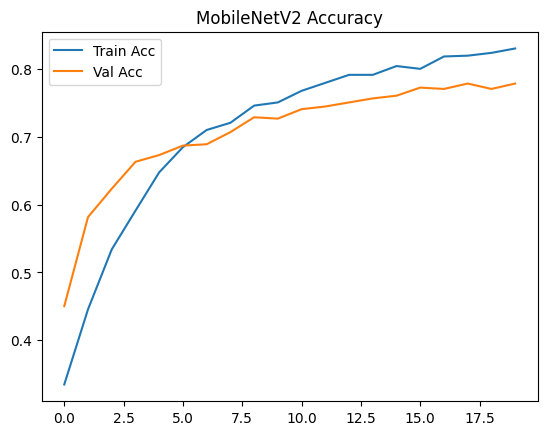

In [ ]:

# 8. Plot history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("MobileNetV2 Accuracy")
plt.show()

In [ ]:

# 9. Evaluate
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7605 - loss: 0.6336
Test Accuracy: 0.7683


In [ ]:
# 10. Save for Streamlit
model.save("mobilenetv2_model.h5")

In [ ]:
from google.colab import files
files.download("mobilenetv2_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>